In [1]:
import json
import pickle
import os
import numpy as np
import pandas as pd
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader
from collections import Counter, defaultdict
from torchtext.vocab import GloVe
import matplotlib.pyplot as plt
from transformers import BertModel, BertTokenizer

In [2]:
# Load the data
train_data = json.load(open('/kaggle/input/text2math/data/train.json'))
dev_data = json.load(open('/kaggle/input/text2math/data/dev.json'))
test_data = json.load(open('/kaggle/input/text2math/data/test.json'))

In [3]:
# Input split by space and creating vocabulary, then mapping the words to integers

# # Creating vocab such that if a word in data occurs more than once, then it is added to the vocab
# def create_prb_vocab(data):
#     vocab = Counter()
#     word_cnt = defaultdict(int)
#     for example in data:
#         for word in example['Problem'].split():
#             word_cnt[word] += 1
#     for word, cnt in word_cnt.items():
#         if cnt > 3:
#             vocab[word] = cnt
#     return vocab


# # Creating the vocabulary
# train_vocab = create_prb_vocab(train_data)
# dev_vocab = create_prb_vocab(dev_data)

# # Store all the train and dev vocab in a single vocab pickle file
# prb_vocab = Counter()
# prb_vocab.update(train_vocab)
# prb_vocab.update(dev_vocab)

In [4]:
# Mapping the words to integers
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
def map_words_to_integers(vocab):
    word2int = {word: i for i, (word, _) in enumerate(vocab.items(), 1)}
    word2int['<pad>'] = 0
    word2int['<sos>'] = len(word2int)
    word2int['<eos>'] = len(word2int)
    word2int['<unk>'] = len(word2int)
    word2int['<num_value>'] = len(word2int)
    word2int['<str_value>'] = len(word2int)

    int2word = {i: word for word, i in word2int.items()}
    return word2int, int2word

# prb_word2int, prb_int2word = map_words_to_integers(prb_vocab)
# prb_word2int['<pad>'] = 0
# prb_int2word[0] = '<pad>'

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [5]:
# prb_word2int, prb_int2word = map_words_to_integers(prb_vocab)
# print('Vocab size:', len(prb_word2int))
# # Print last 10 words in the vocab
# print('Last 10 words in the vocab:', list(prb_word2int.keys())[-10:])
# print('Word to integer mapping:', {k: v for k, v in list(prb_word2int.items())[-10:]})

In [6]:
# Creating vocab for linear formula

# Used the function in evaluator.py to get the vocab for linear formula
lf_ops = ['add', 'subtract', 'divide', 'power', 'multiply', 'negate', 'circle_area', 'square_area', 'rectangle_area', 'volume_cylinder', 'const_', 'floor', 'sqrt', 'circumface', 'inverse', 'factorial', 'log', 'choose', 'rhombus_perimeter', 'rectangle_perimeter', 'quadrilateral_area', 'speed', 'reminder', 'volume_rectangular_prism', 'permutation', 'surface_sphere', 'triangle_area', 'gcd', 'lcm', 'triangle_perimeter', 'p_after_gain', 'triangle_area_three_edges', 'cube_edge_by_volume', 'surface_rectangular_prism', 'square_perimeter', 'max', 'surface_cube', 'volume_cube', 'rhombus_area', 'original_price_before_loss', 'square_edge_by_area', 'volume_cone', 'stream_speed', 'surface_cylinder', 'volume_sphere', 'original_price_before_gain', 'min', 'square_edge_by_perimeter', 'negate_prob']

def create_lf_vocab(data):
    vocab = Counter()
    word_cnt = defaultdict(int)
    answers = [] 
    for example in data:
        words = example['linear_formula'].split('|')
        for op in words:
            if(op == ''):
                continue
            t = op.split('(')
            op = t[0]
            args = t[1].split(')')[0]
            args = args.split(',')
            args = [argsi.strip() for argsi in args]
            for arg in args:
                answers.append(arg)

    for word in answers:
        word_cnt[word] += 1
    for word, cnt in word_cnt.items():
            vocab[word] = cnt
    # vocab = word_cnt
    for i in lf_ops:
        if i not in vocab:
            vocab[i] = 1
    return vocab

# Creating the vocabulary
train_vocab = create_lf_vocab(train_data)
dev_vocab = create_lf_vocab(dev_data)

# Store all the train and dev vocab in a single vocab pickle file
lf_vocab = Counter()
lf_vocab.update(train_vocab)
lf_vocab.update(dev_vocab)

In [7]:
print('Vocab size:', len(lf_vocab))

Vocab size: 142


In [8]:
# Mapping the words to integers
lf_word2int, lf_int2word = map_words_to_integers(lf_vocab)

In [9]:
lf_word2int, lf_int2word = map_words_to_integers(lf_vocab)
print('Vocab size:', len(lf_word2int))
# Print last 10 words in the vocab
print('Last 10 words in the vocab:', list(lf_word2int.keys())[-10:])
print('Word to integer mapping:', {k: v for k, v in list(lf_word2int.items())[-10:]})

Vocab size: 148
Last 10 words in the vocab: ['original_price_before_gain', 'min', 'square_edge_by_perimeter', 'negate_prob', '<pad>', '<sos>', '<eos>', '<unk>', '<num_value>', '<str_value>']
Word to integer mapping: {'original_price_before_gain': 139, 'min': 140, 'square_edge_by_perimeter': 141, 'negate_prob': 142, '<pad>': 0, '<sos>': 143, '<eos>': 144, '<unk>': 145, '<num_value>': 146, '<str_value>': 147}


In [10]:
def tokenising(data):
    tokenised_data = []
    for example in data:
        prb = example['Problem']
#         prb_tokens = [prb_word2int.get(word, prb_word2int['<unk>']) for word in prb.split()]
#         prb_tokens = [prb_word2int['<sos>']] + prb_tokens + [prb_word2int['<eos>']]
        lf = example['linear_formula']
        lf_tokens = []
        lf_tokens.append(lf_word2int['<sos>'])
        for token in lf.split('|'):
            if token == '':
                continue
            t = token.split('(')
            op = t[0]
            args = t[1].split(')')[0]
            args = args.split(',')
            args = [argsi.strip() for argsi in args]
            lf_tokens.append(lf_word2int[op])
            for arg in args:
                if arg.isnumeric():
                    lf_tokens.append(lf_word2int['<num_value>'])
                else:
                    lf_tokens.append(lf_word2int[arg])
        lf_tokens.append(lf_word2int['<eos>'])
        tokenised_data.append((prb, lf_tokens))
    return tokenised_data
    

In [11]:
class text2mathDataset(Dataset):
    def __init__(self, data):
        self.data = tokenising(data)

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]
    
    def collate_fn(self, batch):
        max_len_prb = max([len(prb) for prb, _ in batch])
        max_len_lf = max([len(lf) for _, lf in batch])
        prbs = [prb for prb, _ in batch]
        prbs = tokenizer(prbs, padding=True, truncation=True, return_tensors='pt')
        inputs = prbs['input_ids']
        attention_mask = prbs['attention_mask']
        lfs = torch.zeros((len(batch), max_len_lf), dtype=torch.long)
        lf_lens = torch.zeros(len(batch), dtype=torch.long)
        for idx, (prb, lf) in enumerate(batch):
            lf_lens[idx] = len(lf)
            lfs[idx, :len(lf)] = torch.LongTensor(lf)

        return {'Problem': inputs, 'linear_formula': lfs, 'attention_mask': attention_mask }

In [12]:
train_dataset = text2mathDataset(train_data)
dev_dataset = text2mathDataset(dev_data)

In [13]:
# Pretrained BERT model

class bert_encoder(nn.Module):
    def __init__(self):
        super(bert_encoder, self).__init__()
        bert = BertModel.from_pretrained('bert-base-uncased')
        for param in bert.parameters():
            param.requires_grad = False
        self.encoder = bert 

    def forward(self, input_ids, attention_mask):
        outputs = self.encoder(input_ids, attention_mask=attention_mask)
        return outputs.last_hidden_state
    

class bert_attn_ntwrk(nn.Module):
    def __init__(self, emb_dim, hidden_dim, num_layers):
        super(bert_attn_ntwrk, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.atten = nn.Linear(hidden_dim * 2, hidden_dim)
        self.linear = nn.Linear(hidden_dim, 1, bias=False)
        self.softmax = nn.Softmax(dim=1)
        self.relu = nn.ReLU()

    def forward(self, hidden, encoder_outputs):
        seq_len = encoder_outputs.size(1)
        hidden = hidden.repeat(encoder_outputs.shape[1],1,1)
        hidden = hidden.transpose(0,1)
        energy = F.relu(self.atten(torch.cat((hidden, encoder_outputs), dim=2)))
        attention = F.softmax(self.linear(energy).squeeze(2), dim=1)
        ctxt = torch.bmm(attention.unsqueeze(1), encoder_outputs)
        return ctxt, attention
    

class lstm_bert_decoder(nn.Module):
    def __init__(self, lf_vocab_size, emb_dim, hidden_dim, num_layers):
        super(lstm_bert_decoder, self).__init__()
        self.emb_dim = emb_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.embedding = nn.Embedding(lf_vocab_size, emb_dim)
        self.lstm = nn.LSTM(emb_dim+hidden_dim, hidden_dim, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_dim, lf_vocab_size)
        self.atten = bert_attn_ntwrk(emb_dim, hidden_dim, num_layers)

    def forward(self, input, hidden, cell, encoder_outputs):
        embedded = self.embedding(input)
        embedded = embedded.unsqueeze(1)
#         print("embed",embedded.shape)
        context, attention = self.atten(hidden, encoder_outputs)
#         print("context", context.shape)
#         context = context.unsqueeze(1)
        lstm_input = torch.cat((embedded, context), dim=2)
        output, (hidden, cell) = self.lstm(lstm_input, (hidden, cell))
        output = self.linear(output.squeeze(1))
#         print(output.shape)
        return output, (hidden, cell)
    

class seq2seq_attnbert(nn.Module):
    def __init__(self, bert_encoder, bert_attn_ntwrk, lstm_bert_decoder):
        super(seq2seq_attnbert, self).__init__()
        self.bert_encoder = bert_encoder
        self.bert_attn_ntwrk = bert_attn_ntwrk
        self.lstm_bert_decoder = lstm_bert_decoder

    def forward(self, prb, lf, attention_mask, teacher_forcing_ratio=0.6):
        batch_size = prb.shape[0]
        max_len_lf = lf.shape[1]
        lf_vocab_size = self.lstm_bert_decoder.embedding.num_embeddings
        outputs = torch.zeros(batch_size, max_len_lf, lf_vocab_size).to(device)
        # attention_mask = (prb != 0).to(device)
        encoder_outputs = self.bert_encoder(prb, attention_mask)
        hidden = torch.zeros(self.lstm_bert_decoder.num_layers, batch_size, self.lstm_bert_decoder.hidden_dim).to(device)
        cell = torch.zeros(self.lstm_bert_decoder.num_layers, batch_size, self.lstm_bert_decoder.hidden_dim).to(device)
        input = lf[:, 0]
        for t in range(1, max_len_lf):
#             print(input.shape)
            output, (hidden, cell) = self.lstm_bert_decoder(input, hidden, cell, encoder_outputs)
#             print(output.shape)
            outputs[:, t, :] = output.squeeze(1)
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.argmax(1).squeeze()
            input = lf[:, t] if teacher_force else top1
        return outputs
        
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [14]:
emb_dim = 768
hidden_dim = 768
num_layers = 1

# Model
bert_enc = bert_encoder().to(device)
bert_attn = bert_attn_ntwrk(emb_dim, hidden_dim, num_layers).to(device)
lstm_dec = lstm_bert_decoder(len(lf_word2int), emb_dim, hidden_dim, num_layers).to(device)
model = seq2seq_attnbert(bert_enc, bert_attn, lstm_dec).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=train_dataset.collate_fn)
dev_loader = DataLoader(dev_dataset, batch_size=32, shuffle=False, collate_fn=dev_dataset.collate_fn)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Epoch 1/30, Train Loss: 2.0901
Epoch 1/30, Dev Loss: 1.9085
Epoch 2/30, Train Loss: 1.8489
Epoch 2/30, Dev Loss: 1.8000
Epoch 3/30, Train Loss: 1.7462
Epoch 3/30, Dev Loss: 1.7109
Epoch 4/30, Train Loss: 1.6535
Epoch 4/30, Dev Loss: 1.6152
Epoch 5/30, Train Loss: 1.5653
Epoch 5/30, Dev Loss: 1.5527
Epoch 6/30, Train Loss: 1.4700
Epoch 6/30, Dev Loss: 1.4836
Epoch 7/30, Train Loss: 1.3935
Epoch 7/30, Dev Loss: 1.3939
Epoch 8/30, Train Loss: 1.3172
Epoch 8/30, Dev Loss: 1.3523
Epoch 9/30, Train Loss: 1.2410
Epoch 9/30, Dev Loss: 1.3021
Epoch 10/30, Train Loss: 1.1712
Epoch 10/30, Dev Loss: 1.2260
Epoch 11/30, Train Loss: 1.1184
Epoch 11/30, Dev Loss: 1.1855
Epoch 12/30, Train Loss: 1.0614
Epoch 12/30, Dev Loss: 1.1604
Epoch 13/30, Train Loss: 1.0209
Epoch 13/30, Dev Loss: 1.1292
Epoch 14/30, Train Loss: 0.9883
Epoch 14/30, Dev Loss: 1.0936
Epoch 15/30, Train Loss: 0.9464
Epoch 15/30, Dev Loss: 1.0877
Epoch 16/30, Train Loss: 0.9151
Epoch 16/30, Dev Loss: 1.0659
Epoch 17/30, Train Loss: 0

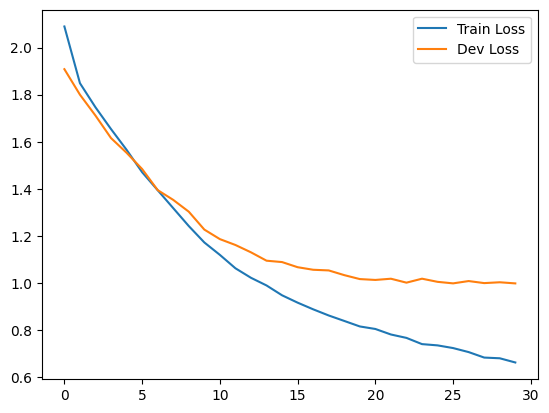

In [15]:
train_len = len(train_loader)
dev_len = len(dev_loader)

num_epochs = 30 
train_losses = []
dev_losses = []
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for i, data in enumerate(train_loader):
        prb = data['Problem'].to(device)
        lf = data['linear_formula'].to(device)
        attn_masks = data['attention_mask'].to(device)
        optimizer.zero_grad()
        outputs = model(prb, lf, attn_masks)
        outputs = outputs.view(-1, len(lf_word2int))
        lf = lf.view(-1)
        loss = criterion(outputs, lf)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= train_len
    train_losses.append(train_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}')

    model.eval()
    dev_loss = 0
    with torch.no_grad():
        for i, data in enumerate(dev_loader):
            prb = data['Problem'].to(device)
            lf = data['linear_formula'].to(device)
            attn_masks = data['attention_mask'].to(device)
            outputs = model(prb, lf, attn_masks)
            outputs = outputs.view(-1, len(lf_word2int))
            lf = lf.view(-1)
            loss = criterion(outputs, lf)
            dev_loss += loss.item()
        dev_loss /= dev_len
        dev_losses.append(dev_loss)
        print(f'Epoch {epoch+1}/{num_epochs}, Dev Loss: {dev_loss:.4f}')


# Save the model
torch.save(model.state_dict(), 'seq2seq_attnbert.pth')

# Plot the loss
plt.plot(train_losses, label='Train Loss')
plt.plot(dev_losses, label='Dev Loss')
plt.legend()
plt.show()